[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Train Soccer Player Detector

---

[![Download Dataset](https://app.roboflow.com/images/download-dataset-badge.svg)](https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc)

This notebook is based on the [How to Train YOLOv8 Object Detection on a Custom Dataset](https://github.com/roboflow/notebooks/blob/main/notebooks/train-yolov8-object-detection-on-custom-dataset.ipynb) notebook from the [roboflow/notebooks](https://github.com/roboflow/notebooks) repository.

## Configure API keys

- Open your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Wed Nov 12 17:09:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install dependencies

In [3]:
!pip install -q ultralytics roboflow

## Imports

In [4]:
from roboflow import Roboflow
from google.colab import userdata
from IPython.display import Image

## Pull dataset

In [5]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("roboflow-jvuqo").project("football-players-detection-3zvbc")
version = project.version(20)
dataset = version.download("yolov8")

mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
loading Roboflow workspace...
loading Roboflow project...


**NOTE:** Update `data.yaml` structure to align with the latest requirements of the `ultralytics` package.



In [6]:
!sed -i 's|\(train: \).*|\1../train/images|' {dataset.location}/data.yaml
!sed -i 's|\(val: \).*|\1../valid/images|' {dataset.location}/data.yaml

In [7]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

## Custom training

In [8]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml batch=2 epochs=50 imgsz=640 plots=True

/content
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=2, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/football-players-detection-20/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10

In [21]:
!ls {HOME}/runs/detect/train3/

args.yaml			 results.csv	      val_batch0_labels.jpg
BoxF1_curve.png			 results.png	      val_batch0_pred.jpg
BoxP_curve.png			 train_batch0.jpg     val_batch1_labels.jpg
BoxPR_curve.png			 train_batch1.jpg     val_batch1_pred.jpg
BoxR_curve.png			 train_batch2.jpg     val_batch2_labels.jpg
confusion_matrix_normalized.png  train_batch5960.jpg  val_batch2_pred.jpg
confusion_matrix.png		 train_batch5961.jpg  weights
labels.jpg			 train_batch5962.jpg


/content


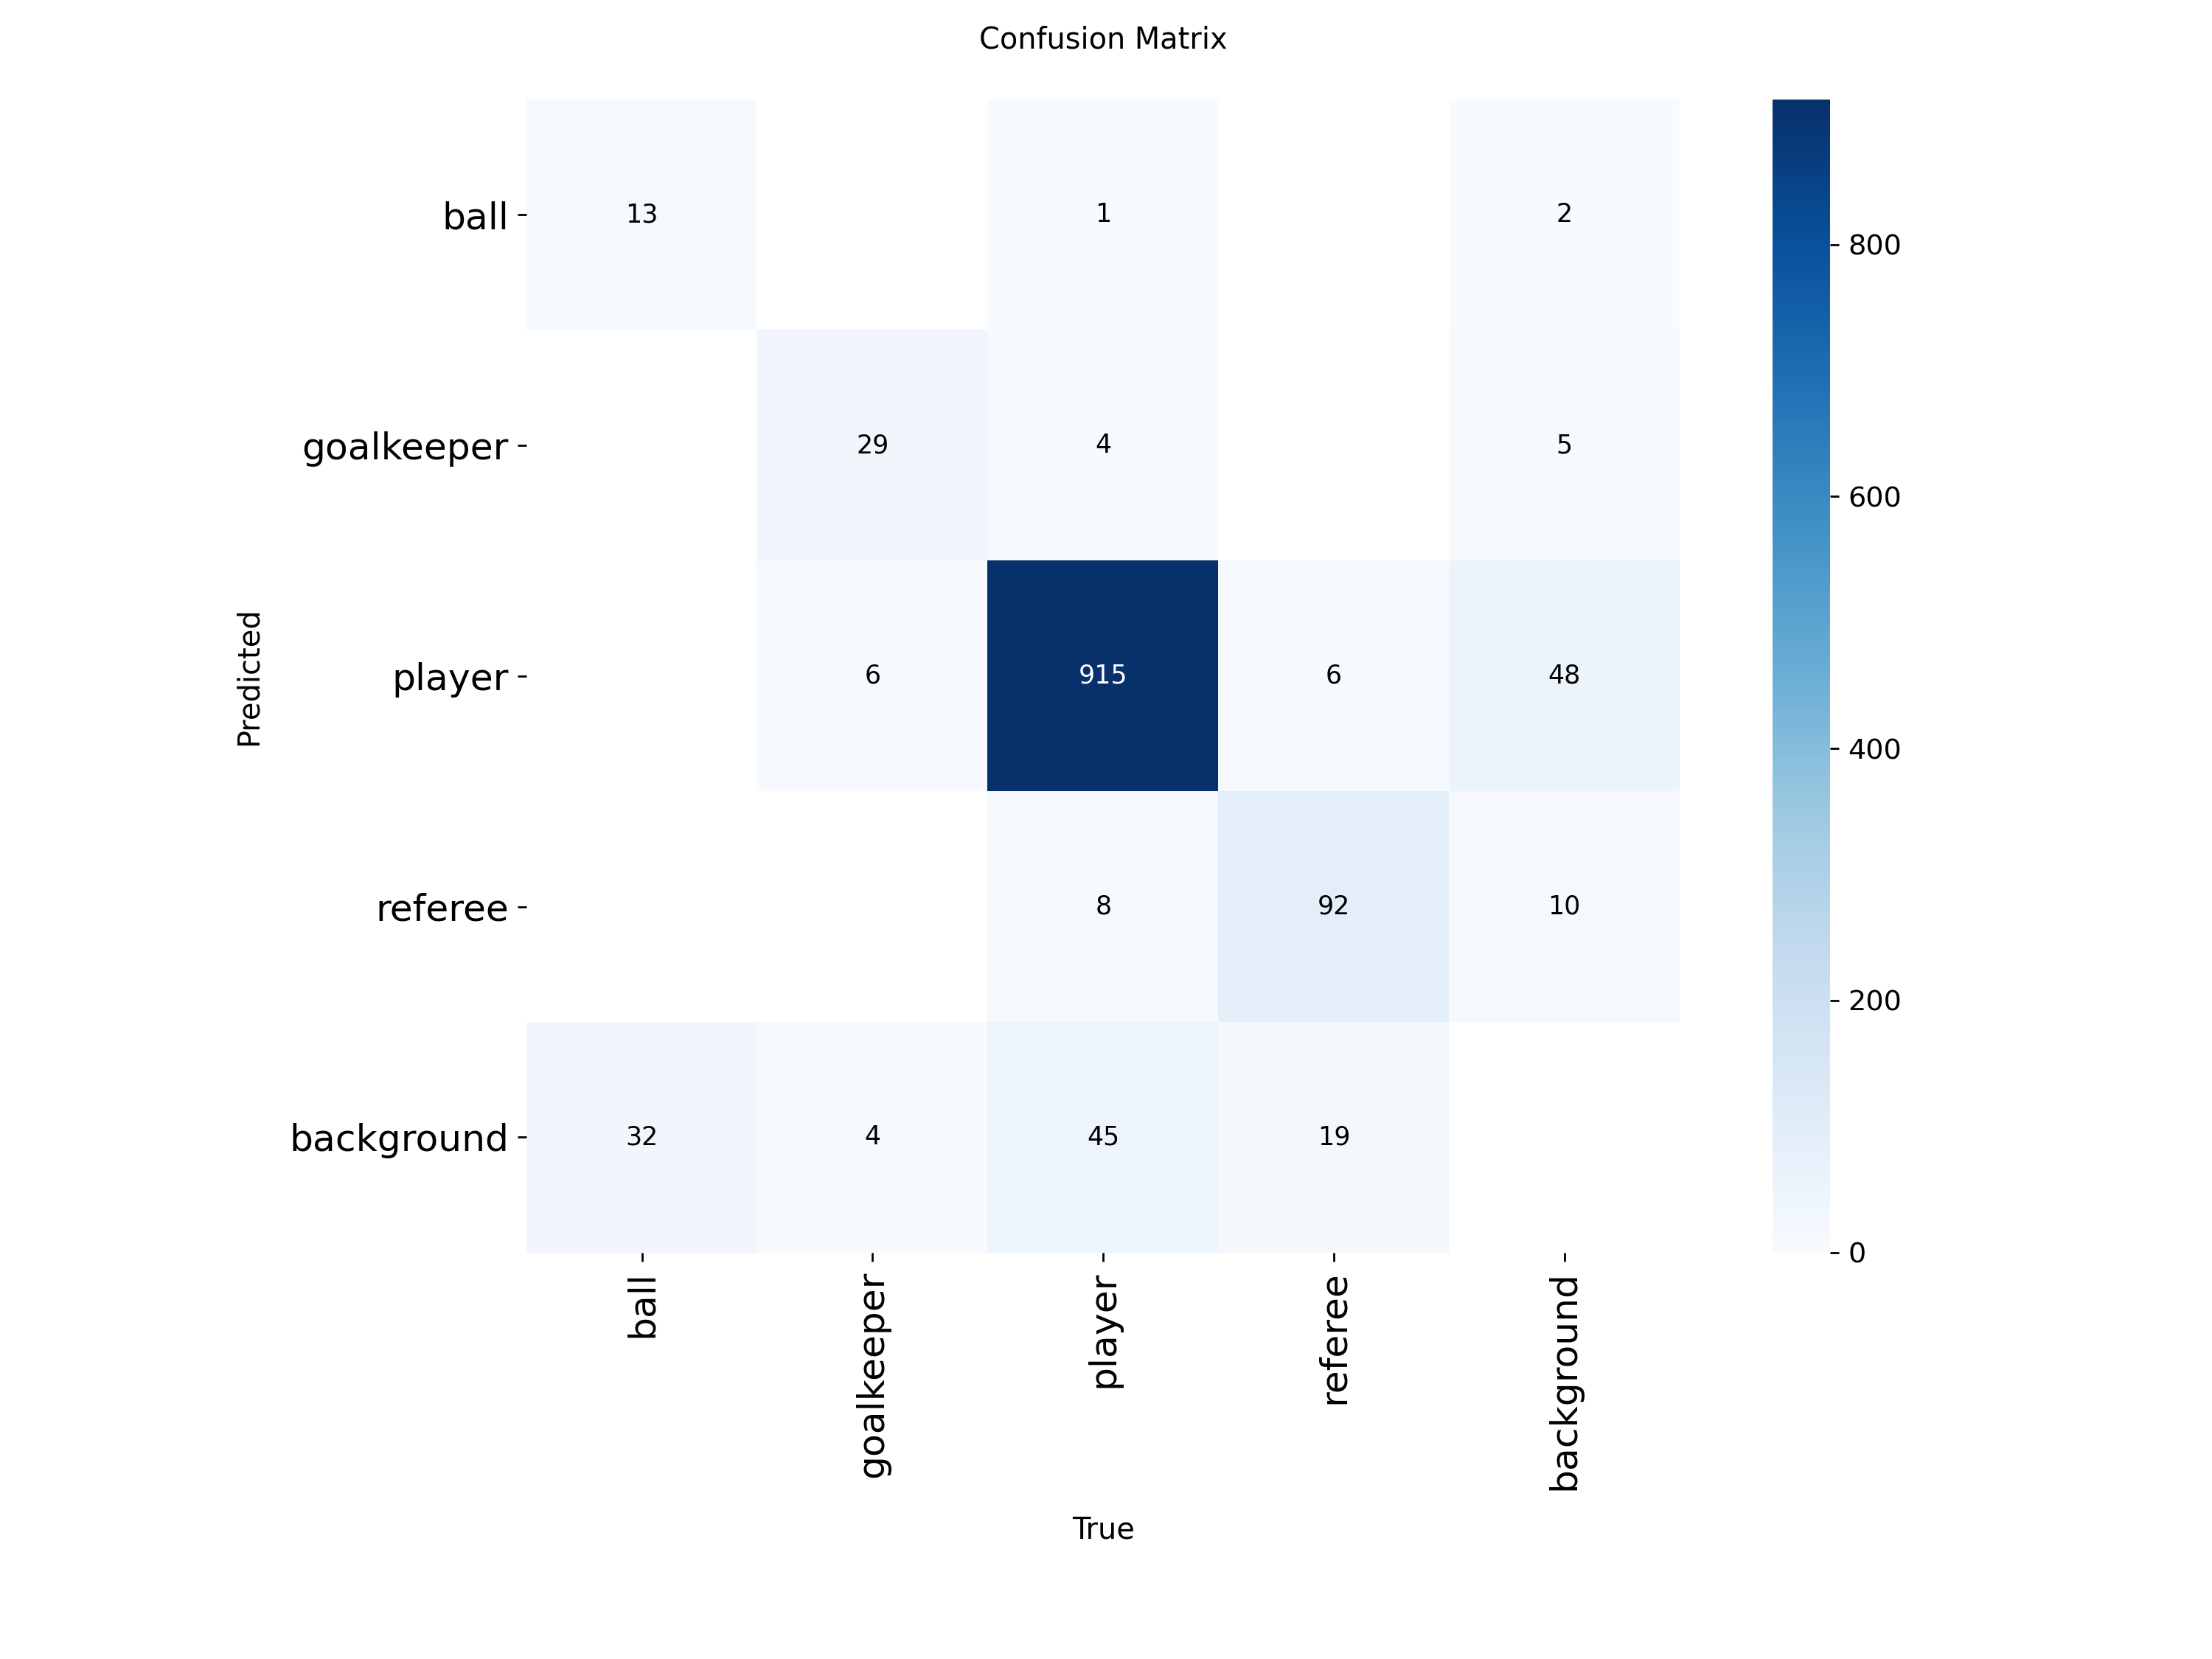

In [22]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train3/confusion_matrix.png', width=600)

/content


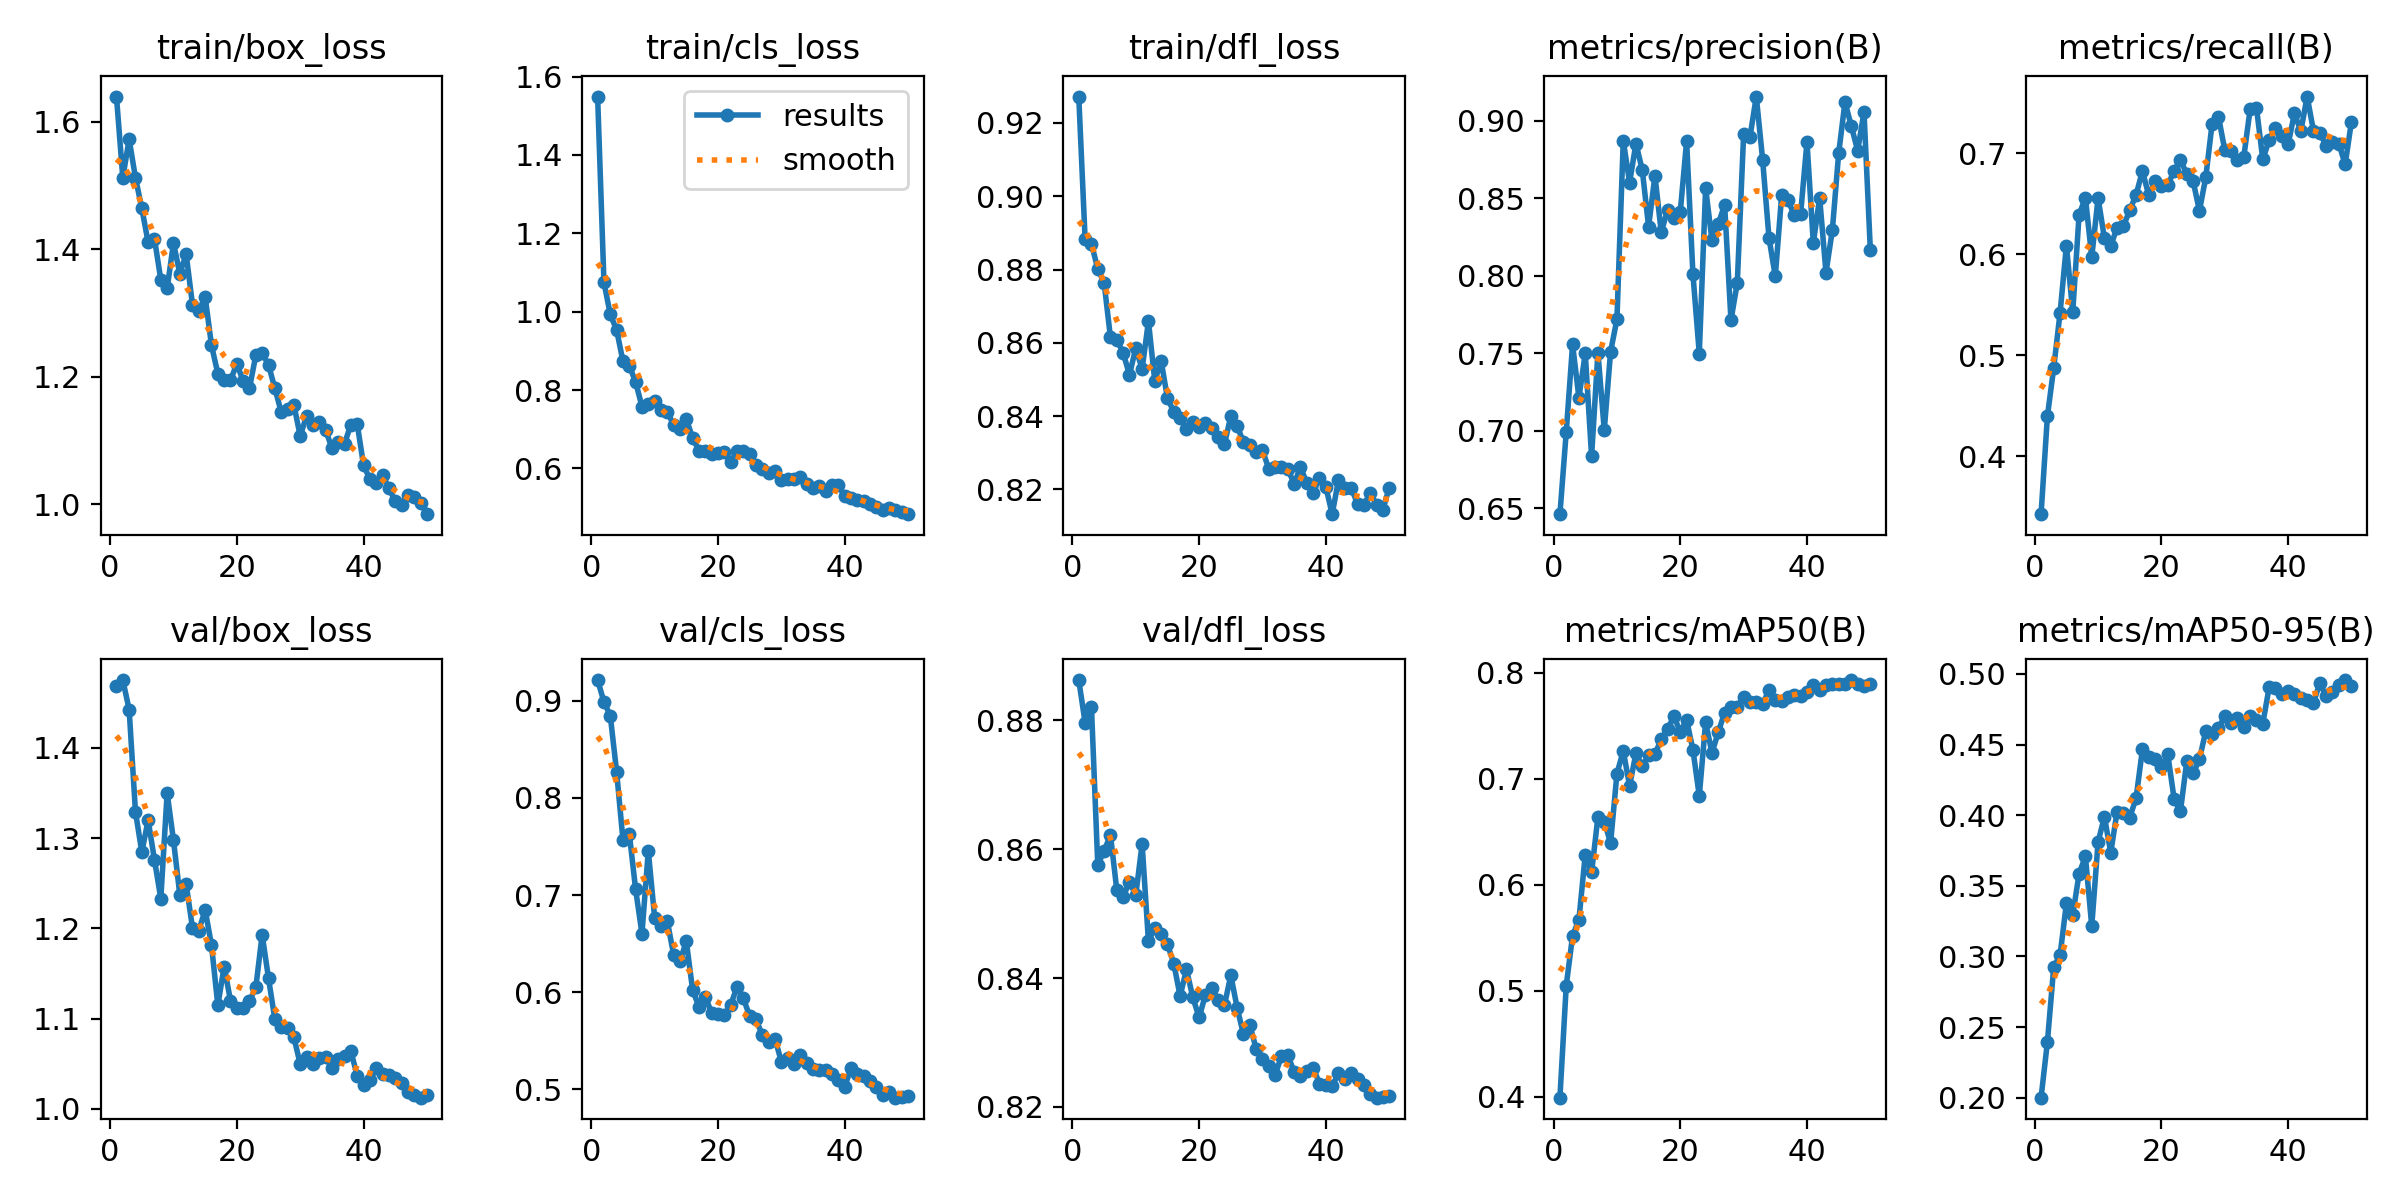

In [23]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train3/results.png', width=600)

/content


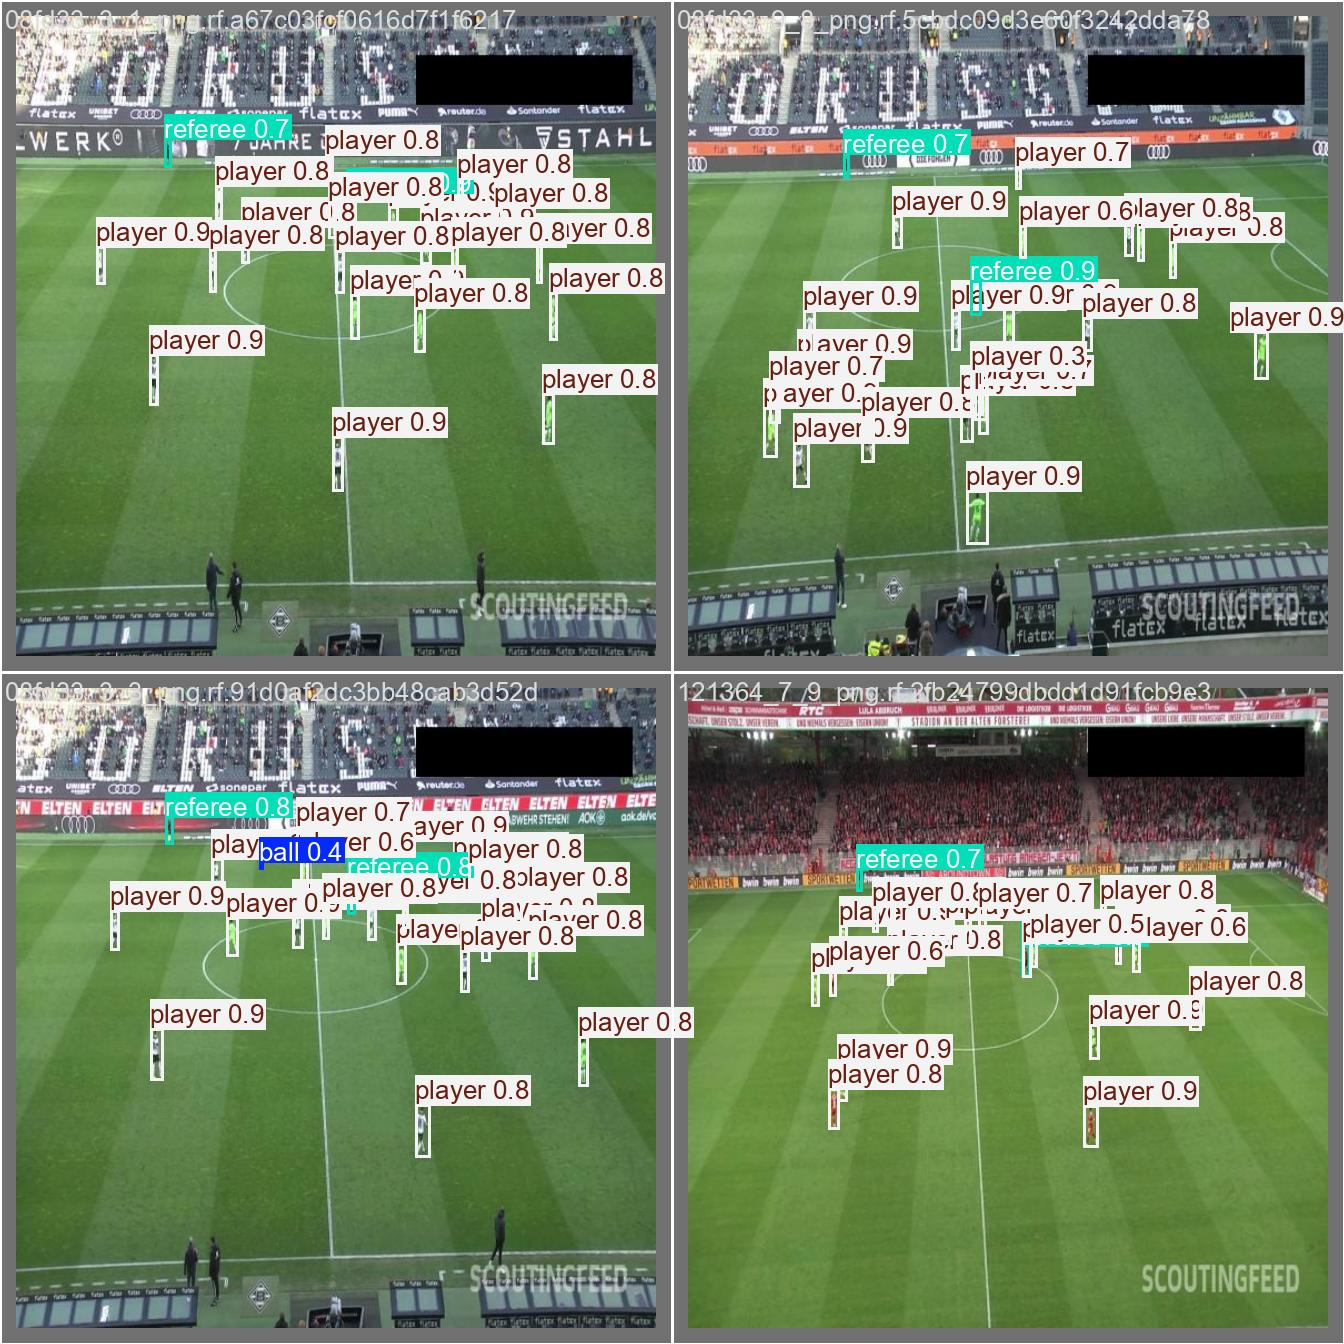

In [25]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train3/val_batch0_pred.jpg', width=600)

## Validate custom model

In [26]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train3/weights/best.pt data={dataset.location}/data.yaml imgsz=640

/content
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2002.3±485.4 MB/s, size: 53.8 KB)
val: Scanning /content/datasets/football-players-detection-20/valid/labels.cache... 49 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 49/49 909.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 1.1it/s 3.6s
                   all         49       1174      0.905      0.689      0.788      0.498
                  ball         45         45      0.891      0.267      0.391      0.136
            goalkeeper         38         39      0.858      0.795      0.887      0.598
                player         49        973      0.963      0.931      0.981      0.709
               referee         49        117      0.909      0.764      0.892      0.549
Speed: 11.5

## Deploy model on Roboflow

In [28]:
!pip install ultralytics==8.0.196

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.1/631.1 kB 21.1 MB/s eta 0:00:00
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.3.228
    Uninstalling ultralytics-8.3.228:
      Successfully uninstalled ultralytics-8.3.228


In [29]:
project.version(dataset.version).deploy(model_type="yolov8", model_path=f"{HOME}/runs/detect/train3/")

Dependency ultralytics==8.0.196 is required but found version=8.3.228, to fix: `pip install ultralytics==8.0.196`
Would you like to continue with the wrong version of ultralytics? y/n: y


ImportError: cannot import name 'yaml_load' from 'ultralytics.utils' (/usr/local/lib/python3.12/dist-packages/ultralytics/utils/__init__.py)